In [1]:
import os, random, math, sys
from PIL import Image
import numpy as np
import keras
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Input, AveragePooling2D, Reshape,Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras import backend as K
from keras.regularizers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" #On rd010532 0 = Tesla, 1 = Quadro

In [3]:
def draw_model_on_interactive_session(model):

    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))


In [4]:
def scale(images):
    return (images-127.5)/127.5 #scale

def undo_scale(images):
    return images*127.5 + 127.5
    

In [7]:
def load_motorbike_images():
    motorbike_images = [x for x in os.listdir('.') if 'jpg' in x]
    
    aspect_ratio = 1.66
    
    training_data = []
    for motorbike in motorbike_images:
        im = Image.open(motorbike)        
        im = im.resize((56, 32), Image.BILINEAR)
        im=np.array(im)
        
        if im.ndim == 3:
            training_data.append(im)

    return np.array(training_data).astype(float)

In [8]:
X_train = load_motorbike_images()

X_train = scale(X_train)
print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


-1.0 1.0
X_train shape: (819, 32, 56, 3)
819 train samples


In [9]:
56 * 32 *3

5376

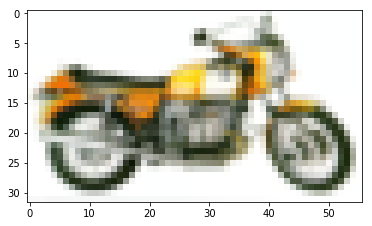

In [10]:
plt.imshow(undo_scale(X_train[0]).astype('uint8'))
plt.show()


In [11]:
latent_space_size = 100

def create_new_networks():
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_generator_stack = generator_containing_discriminator(generator, discriminator)

    discriminator_optimiser = Adagrad()#SGD(lr=0.0001, momentum=0.9, nesterov=True)
    generator_optimiser = Adagrad()#SGD(lr=0.0003, momentum=0.9, nesterov=True)
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    discriminator_generator_stack.compile(loss='binary_crossentropy', optimizer=generator_optimiser)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimiser)

    return discriminator, generator, discriminator_generator_stack


In [12]:
# Build Generative model ...

def generator_model():
    model = Sequential()
    model.add(Dense(336, input_shape=(latent_space_size,), activation='tanh'))
    
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((8, 14, 3)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(3, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

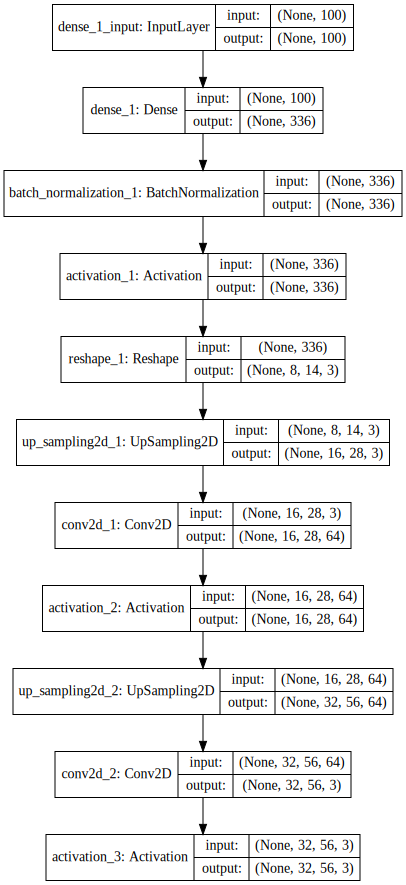

In [13]:
draw_model_on_interactive_session(generator_model())

In [14]:
# Build Discriminative model ...
def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(32, 56, 3))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

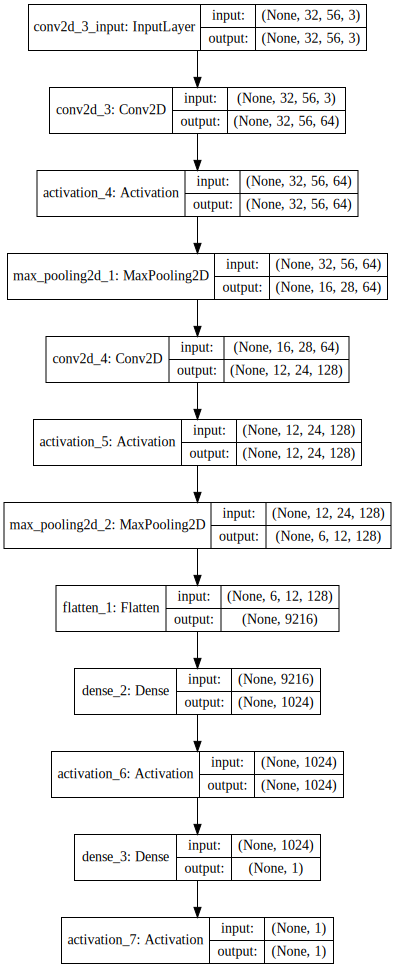

In [15]:
draw_model_on_interactive_session(discriminator_model())

In [16]:
# Build stacked GAN model
# need new loss function here? Maximise entropy between two classes while
#discriminator is trying to reduce it?
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    
    return model

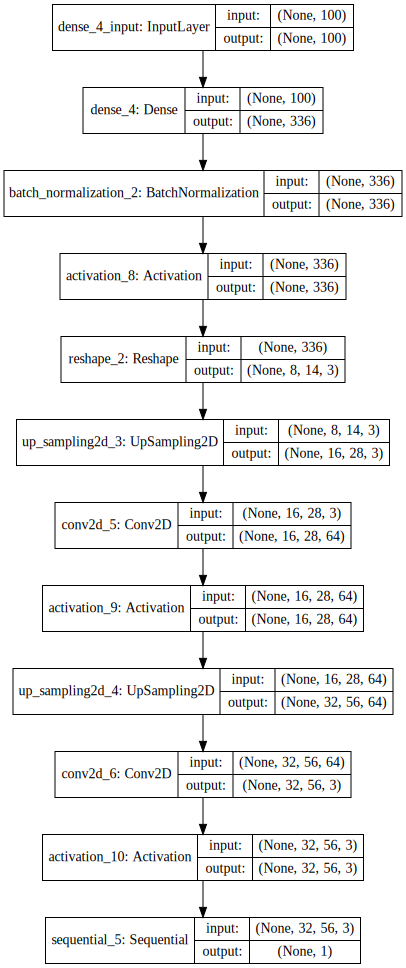

In [17]:
draw_model_on_interactive_session(generator_containing_discriminator(generator_model(), discriminator_model()))
                                  

In [18]:


def plot_loss(losses):   
    
    if ax.lines:
        ax.lines[0].set_data(list(range(len(losses["d_loss"]))), losses["d_loss"])
        ax.lines[1].set_data(list(range(len(losses["g"]))), losses["g"])
        ax.lines[2].set_data(list(range(len(losses["accuracy"]))), losses["accuracy"])
        ax.autoscale(True)
        
    else:        
        ax.plot(list(range(len(losses["d_loss"]))), losses["d_loss"], label='discriminator loss (real)')
        ax.plot(list(range(len(losses["g"]))), losses["g"], label='generator loss')
        ax.plot(list(range(len(losses["accuracy"]))), losses["accuracy"], label='accuracy')
        ax.autoscale()        
        
    ax.relim()
    ax.autoscale_view()
    ax.legend(['Discriminator Loss', 'Generator Loss', 'Discriminator Accuracy'])
    fig.canvas.draw()

    
def plot_generated_images(n_ex=16,dim=(4,4), figsize=(10,10), noise=None ):
    
    if noise is None:
        noise = np.random.normal(-1,1,size=[n_ex,latent_space_size])
        
    generated_images = generator.predict(noise)
        
    for i in range(n_ex):
        
        img = undo_scale(generated_images[i]).astype('uint8')
        generated_image_axes[i].set_data(img)

    plt.show()
    image_fig.canvas.draw()


In [19]:
def perform_discriminator_training_steps(training_data, start, batch_size=50):
    
    discriminator.trainable = True

    X_real, y_real = generate_discriminator_training_batch(True, training_data, start, batch_size)
    X_fake, y_fake = generate_discriminator_training_batch(False, training_data, start, batch_size)

    X = np.concatenate([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])
    discriminator_history = discriminator.train_on_batch(X,y)
    losses['d_loss'].append(discriminator_history)
    
    

In [20]:
def generate_discriminator_training_batch(real, training_data, start, batch_size):
  
    # 1 is a real sample, 0 is generated. But use a range of values
    # around 1 or 0 to add some noise to help the training
  
    if real:
        X = training_data[range(start, start+batch_size),:,:,:]       
        y=np.ones(batch_size)
    else:        
        noise_gen = np.random.normal(-1,1,size=[batch_size,latent_space_size])
        X = generator.predict(noise_gen)            
        y=np.zeros(batch_size)
    
    return X, y

In [21]:
 # train Generator-Discriminator stack on input noise to non-generated output class
def perform_generator_discriminator_stack_training_steps(batch_size=50):
    #(1.1 - 0.9) *np.random.random_sample((batch_size,)) + 0.9
    
    discriminator.trainable=False

    noise_input = np.random.normal(-1,1,size=[batch_size, latent_space_size])
    y = np.ones(batch_size)
    gan_history = discriminator_generator_stack.train_on_batch(noise_input, y)
    losses['g'].append(gan_history)



In [22]:
losses = {'d_loss':[], 'g':[], 'accuracy':[]}

<IPython.core.display.Javascript object>


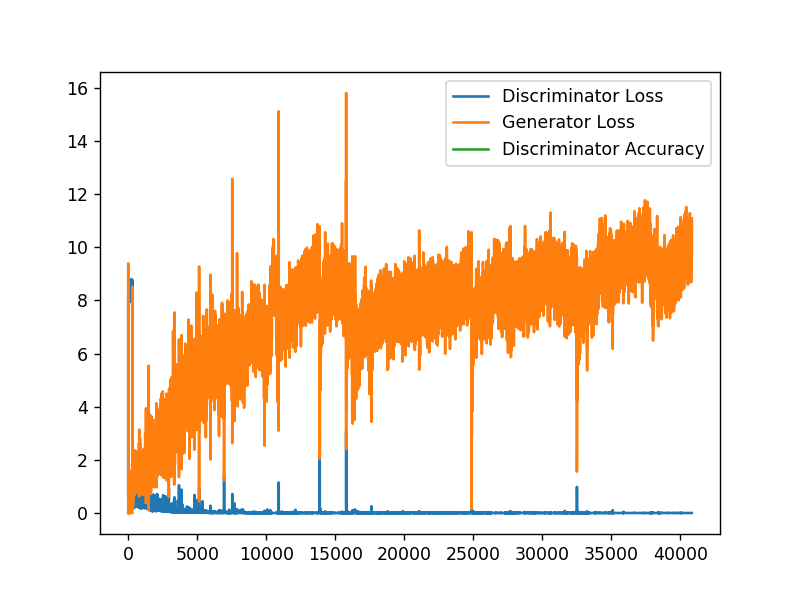

<IPython.core.display.Javascript object>


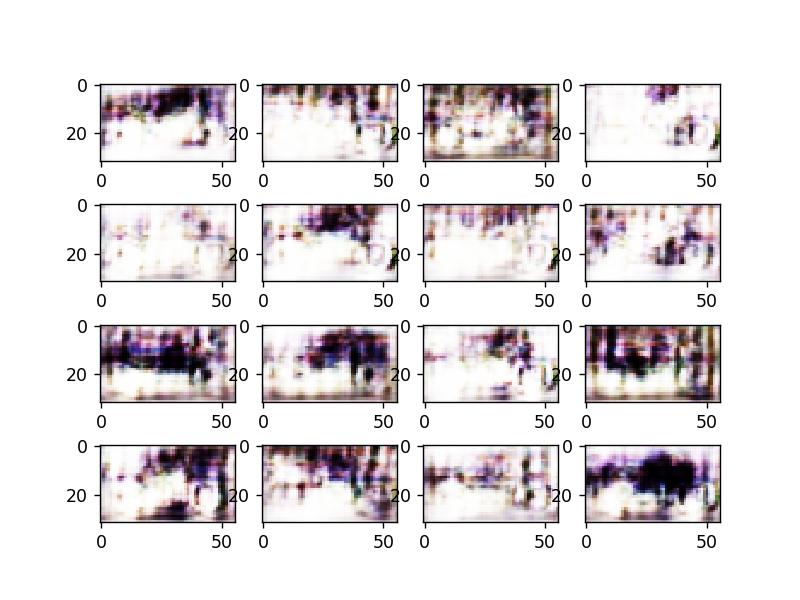

In [23]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1)

image_fig, image_ax = plt.subplots(4, 4)
generated_image_axes = []

for i in range(4):
    for j in range(4):
        generated_image_axes.append(image_ax[i][j].imshow(np.random.randint(0,255,size=[32, 56, 3]).astype('uint8')))
        #generated_image_axes.append(image_ax[i][j].imshow(np.random.rand(32, 56, 3)))

def train(training_data, file_label):

    training_data_size=training_data.shape[0]
    n_batches = int(training_data_size/batch_size)
    print('number of batches: ', n_batches)

    for i in range(600):
        print('epoch: ', i)

        training_data_index=0

        for train_batch in range(n_batches):
            perform_discriminator_training_steps(training_data, training_data_index, batch_size)
            perform_generator_discriminator_stack_training_steps(batch_size)

            training_data_index += batch_size
            

        if i % 1 == 0:
            fig
            plot_loss(losses)
            image_fig
            plot_generated_images()
        if i%10 == 0:
            generator.save(file_label + '_generator.h5')
            discriminator.save(file_label + '_discriminator.h5')
    
    generator.save(file_label + '_generator.h5')
    discriminator.save(file_label + '_discriminator.h5')

In [24]:
discriminator, generator, discriminator_generator_stack = create_new_networks()
    
batch_size = 10

In [ ]:
train(X_train, 'motorbike')

number of batches:  81
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  

In [5]:
batch_size=10
latent_space_size=100
generator = keras.models.load_model('motorbike_generator.h5')

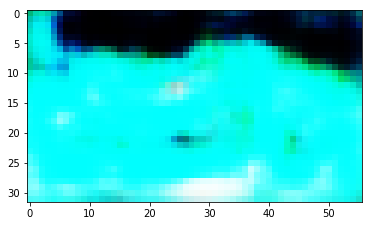

In [6]:

noise_gen = np.random.normal(-1,1,size=[batch_size,latent_space_size])
X = generator.predict(noise_gen)   
X = undo_scale(X).astype('uint8')
bike_fig, _ = plt.subplots(1, 1)
a = plt.imshow(X[0,:,:,:])
plt.show()



In [ ]:
noise_gen = np.random.normal(-1,1,size=[batch_size,latent_space_size])
X = generator.predict(noise_gen)   
X = undo_scale(X).astype('uint8')
#X=np.zeros(X.shape)
a.set_data(X[0,:,:,:])